In [3]:
pip install rouge-score pytesseract transformers

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=84a509dfa734efce9553f4627d8fb5ae6f1d4b8cbda42be1c2b0ef7b0431c87b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 66.1 MB/s eta 0:00:00


In [5]:

import os
import fitz  # PyMuPDF
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForTokenClassification, pipeline
from rouge_score import rouge_scorer
import warnings
from sklearn.exceptions import ConvergenceWarning
import pytesseract
from PIL import Image
import io
import joblib
import torch
import torch.nn as nn
import transformers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Configuration
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 8
    EPOCHS = 10
    BASE_MODEL_PATH = "bert-base-uncased"
    MODEL_PATH = "model.bin"
    TRAINING_FILE = "/content/sample_data/ner.csv"  # path to your training data file
    TOKENIZER = transformers.BertTokenizer.from_pretrained(BASE_MODEL_PATH, do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# NER Model Definition
class EntityModel(nn.Module):
    def __init__(self, num_tag, num_pos):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.num_pos = num_pos
        self.bert = transformers.BertModel.from_pretrained(config.BASE_MODEL_PATH)
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)

    def forward(self, ids, mask, token_type_ids, target_pos, target_tag):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        sequence_output = outputs[0]
        bo_tag = self.bert_drop_1(sequence_output)
        bo_pos = self.bert_drop_2(sequence_output)
        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)

        loss_tag = self.loss_fn(tag, target_tag, mask, self.num_tag)
        loss_pos = self.loss_fn(pos, target_pos, mask, self.num_pos)

        loss = (loss_tag + loss_pos) / 2
        return tag, pos, loss

    def loss_fn(self, output, target, mask, num_labels):
        lfn = nn.CrossEntropyLoss()
        active_loss = mask.view(-1) == 1
        active_logits = output.view(-1, num_labels)
        active_labels = torch.where(active_loss, target.view(-1), torch.tensor(lfn.ignore_index).type_as(target))
        loss = lfn(active_logits, active_labels)
        return loss


In [7]:
# Dataset Processing
class EntityDataset:
    def __init__(self, texts, pos, tags):
        self.texts = texts
        self.pos = pos
        self.tags = tags

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        pos = self.pos[item]
        tags = self.tags[item]
        ids, target_pos, target_tag = [], [], []

        for i, s in enumerate(text):
            inputs = config.TOKENIZER.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_pos.extend([pos[i]] * input_len)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:config.MAX_LEN - 2]
        target_pos = target_pos[:config.MAX_LEN - 2]
        target_tag = target_tag[:config.MAX_LEN - 2]

        ids = [101] + ids + [102]
        target_pos = [0] + target_pos + [0]
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = config.MAX_LEN - len(ids)
        ids += [0] * padding_len
        mask += [0] * padding_len
        token_type_ids += [0] * padding_len
        target_pos += [0] * padding_len
        target_tag += [0] * padding_len

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }


In [19]:
# Data Preprocessing
def process_data(data_path):
    try:
        # Try to load the CSV with error handling for malformed lines
        df = pd.read_csv(data_path, encoding="latin-1", on_bad_lines='skip')
        df = df.dropna(subset=['word', 'pos', 'tag'])
        df.loc[:, "sentence_idx"] = df["sentence_idx"].fillna(method="ffill")

        # Encoding POS and TAG columns
        enc_pos = preprocessing.LabelEncoder()
        enc_tag = preprocessing.LabelEncoder()
        df.loc[:, "pos"] = enc_pos.fit_transform(df["pos"])
        df.loc[:, "tag"] = enc_tag.fit_transform(df["tag"])

        # Grouping words, POS, and tags by sentence_idx
        sentences = df.groupby("sentence_idx")["word"].apply(list).values
        pos = df.groupby("sentence_idx")["pos"].apply(list).values
        tag = df.groupby("sentence_idx")["tag"].apply(list).values
        return sentences, pos, tag, enc_pos, enc_tag

    except Exception as e:
        print(f"Error processing data: {e}")
        return None, None, None, None, None


In [20]:
# Training and Evaluation Functions
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, _, loss = model(**data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    correct_tag = 0
    total_tag = 0
    correct_pos = 0
    total_pos = 0

    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)

        # Forward pass
        tag_preds, pos_preds, loss = model(**data)

        # Calculate loss
        final_loss += loss.item()

        # Get the predicted tags and positions
        tag_preds = torch.argmax(tag_preds, dim=2)  # [batch_size, seq_length]
        pos_preds = torch.argmax(pos_preds, dim=2)  # [batch_size, seq_length]

        # Mask to ignore padding tokens
        mask_tag = data['mask']
        mask_pos = data['mask']

        # Ensure correct shape for comparison (using masked values)
        for i in range(tag_preds.size(0)):  # Iterate over the batch size
            for j in range(tag_preds.size(1)):  # Iterate over the sequence length
                if mask_tag[i, j] == 1:  # Only consider real tokens (not padded)
                    total_tag += 1
                    if tag_preds[i, j] == data['target_tag'][i, j]:
                        correct_tag += 1

                if mask_pos[i, j] == 1:  # Only consider real tokens (not padded)
                    total_pos += 1
                    if pos_preds[i, j] == data['target_pos'][i, j]:
                        correct_pos += 1

    # Calculate accuracies
    tag_accuracy = correct_tag / total_tag if total_tag > 0 else 0
    pos_accuracy = correct_pos / total_pos if total_pos > 0 else 0

    # Return the loss and accuracies
    return final_loss / len(data_loader), tag_accuracy, pos_accuracy

In [ ]:
# Model Training
sentences, pos, tag, enc_pos, enc_tag = process_data(config.TRAINING_FILE)

if sentences is None or pos is None or tag is None:
    print("Error: Data processing failed. Check the dataset.")
else:
    meta_data = {"enc_pos": enc_pos, "enc_tag": enc_tag}
    joblib.dump(meta_data, "meta.bin")

    num_pos = len(list(enc_pos.classes_))
    num_tag = len(list(enc_tag.classes_))

    train_sentences, test_sentences, train_pos, test_pos, train_tag, test_tag = model_selection.train_test_split(
        sentences, pos, tag, random_state=42, test_size=0.1
    )

    train_dataset = EntityDataset(texts=train_sentences, pos=train_pos, tags=train_tag)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, num_workers=4)

    valid_dataset = EntityDataset(texts=test_sentences, pos=test_pos, tags=test_tag)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EntityModel(num_tag=num_tag, num_pos=num_pos)
    model.to(device)

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.001,
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train_sentences) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

    best_loss = np.inf
    # Initialize empty lists to store the loss values per epoch
    train_loss = []
    valid_loss = []
    tag_accuracy_per_epoch = []  # List to store Tag accuracy values
    pos_accuracy_per_epoch = []  # List to store POS accuracy values


    # Model training loop
    for epoch in range(config.EPOCHS):
        # Get the training and validation loss for this epoch
        epoch_train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler)
        epoch_valid_loss, tag_accuracy, pos_accuracy = eval_fn(valid_data_loader, model, device)

        # Append the epoch losses to the respective lists
        train_loss.append(epoch_train_loss)
        valid_loss.append(epoch_valid_loss)
        # Append the accuracy values to the respective lists
        tag_accuracy_per_epoch.append(tag_accuracy)
        pos_accuracy_per_epoch.append(pos_accuracy)

        # Print the losses and accuracy for the current epoch
        print(f"Epoch {epoch + 1}/{config.EPOCHS} -> Train Loss = {epoch_train_loss} Valid Loss = {epoch_valid_loss}")
        print(f"Epoch {epoch + 1}/{config.EPOCHS} -> Tag Accuracy = {tag_accuracy:.4f} Pos Accuracy = {pos_accuracy:.4f}")

        # Save the best model based on validation loss
        if epoch_valid_loss < best_loss:
            torch.save(model.state_dict(), config.MODEL_PATH)
            best_loss = epoch_valid_loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 162/162 [00:23<00:00,  6.79it/s]


Epoch 1/10 -> Train Loss = 0.48083270675715667 Valid Loss = 0.15805643435889555
Epoch 1/10 -> Tag Accuracy = 0.9492 Pos Accuracy = 0.9727


100%|██████████| 162/162 [00:24<00:00,  6.75it/s]


Epoch 2/10 -> Train Loss = 0.13873745476411395 Valid Loss = 0.13212888438346576
Epoch 2/10 -> Tag Accuracy = 0.9541 Pos Accuracy = 0.9770


100%|██████████| 162/162 [00:24<00:00,  6.73it/s]


Epoch 3/10 -> Train Loss = 0.10600817998866076 Valid Loss = 0.12613312517189318
Epoch 3/10 -> Tag Accuracy = 0.9551 Pos Accuracy = 0.9780


100%|██████████| 162/162 [00:30<00:00,  5.33it/s]


Epoch 4/10 -> Train Loss = 0.08551887852799137 Valid Loss = 0.12432378927176749
Epoch 4/10 -> Tag Accuracy = 0.9563 Pos Accuracy = 0.9785


100%|██████████| 162/162 [00:23<00:00,  6.82it/s]


Epoch 5/10 -> Train Loss = 0.07055856527622081 Valid Loss = 0.12056731285504353
Epoch 5/10 -> Tag Accuracy = 0.9578 Pos Accuracy = 0.9790


100%|██████████| 162/162 [00:25<00:00,  6.47it/s]


Epoch 6/10 -> Train Loss = 0.058803597767901485 Valid Loss = 0.12261776297272724
Epoch 6/10 -> Tag Accuracy = 0.9556 Pos Accuracy = 0.9796


100%|██████████| 162/162 [00:24<00:00,  6.56it/s]


Epoch 7/10 -> Train Loss = 0.04970101342015687 Valid Loss = 0.12770884372523905
Epoch 7/10 -> Tag Accuracy = 0.9567 Pos Accuracy = 0.9798


100%|██████████| 162/162 [00:24<00:00,  6.59it/s]


Epoch 8/10 -> Train Loss = 0.0427882494687131 Valid Loss = 0.13265972869631684
Epoch 8/10 -> Tag Accuracy = 0.9564 Pos Accuracy = 0.9796


100%|██████████| 162/162 [00:25<00:00,  6.45it/s]


Epoch 9/10 -> Train Loss = 0.03799125199147164 Valid Loss = 0.13649375152624685
Epoch 9/10 -> Tag Accuracy = 0.9559 Pos Accuracy = 0.9794


 39%|███▉      | 142/363 [01:29<02:17,  1.61it/s]

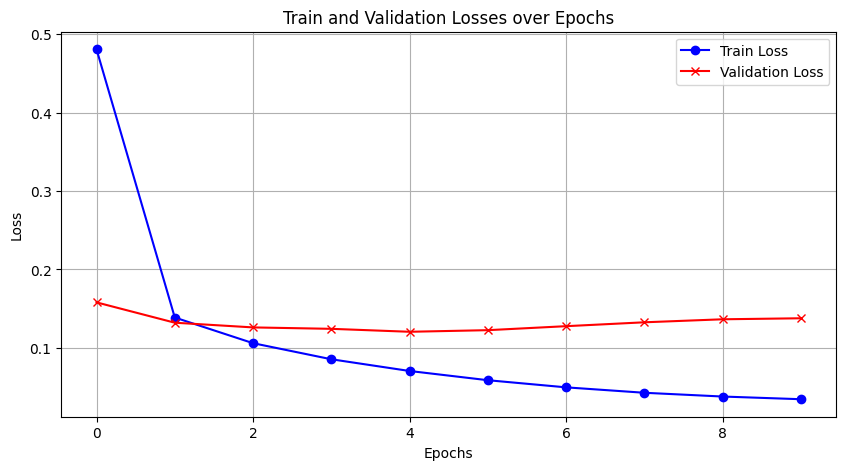

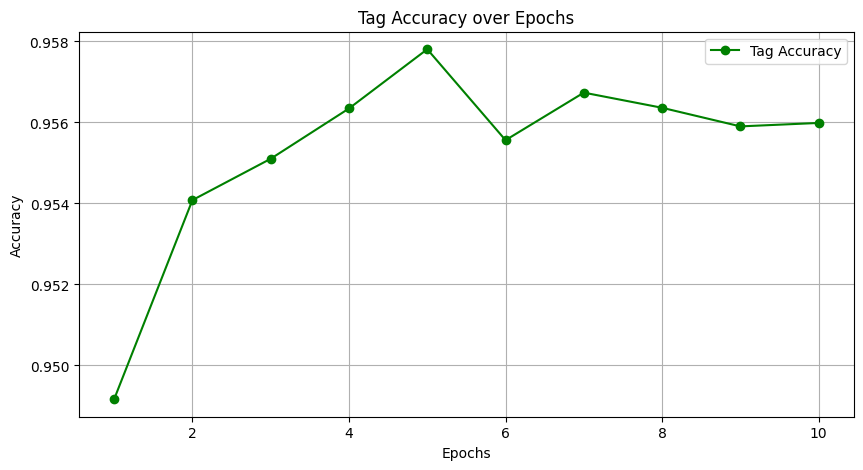

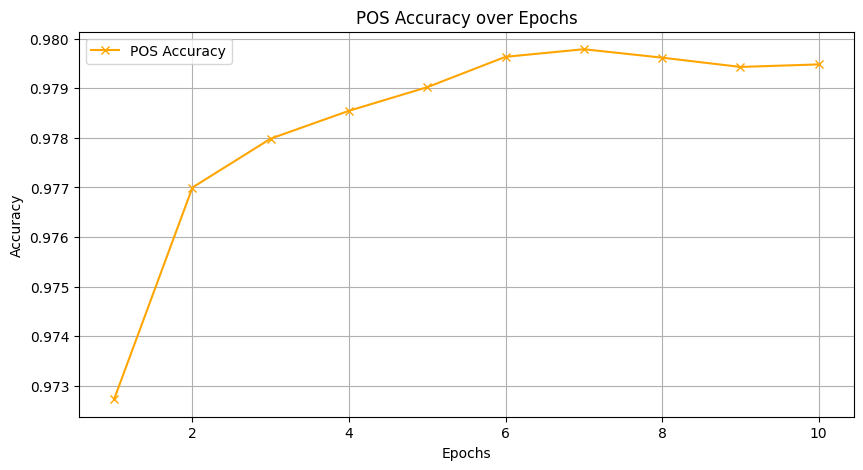

In [47]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss', color='blue', marker='o')
plt.plot(valid_loss, label='Validation Loss', color='red', marker='x')
plt.title('Train and Validation Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting tag accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, config.EPOCHS + 1), tag_accuracy_per_epoch, label='Tag Accuracy', color='green', marker='o')
plt.title('Tag Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting POS accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, config.EPOCHS + 1), pos_accuracy_per_epoch, label='POS Accuracy', color='orange', marker='x')
plt.title('POS Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import torch
import joblib

# Load meta data
meta_data = joblib.load("meta.bin")
enc_pos = meta_data["enc_pos"]
enc_tag = meta_data["enc_tag"]

num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))

# Input sentence
sentence = "abhishek is going to india"
print(f"Original sentence: {sentence}")

# Tokenize the sentence (ensure correct formatting with padding/truncation if necessary)
tokenized_sentence = config.TOKENIZER.encode(sentence, padding=True, truncation=True, return_tensors="pt")
print(f"Tokenized sentence: {tokenized_sentence}")

# Prepare sentence (split into words)
sentence_split = sentence.split()
print(f"Sentence split into words: {sentence_split}")

# Prepare dataset (POS and tags are placeholders for testing)
test_dataset = EntityDataset(
    texts=[sentence_split],
    pos=[[0] * len(sentence_split)],  # Placeholder POS
    tags=[[0] * len(sentence_split)]  # Placeholder tags
)

# Set device (ensure that the model and data are on the same device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and load model
model = EntityModel(num_tag=num_tag, num_pos=num_pos)
model.load_state_dict(torch.load(config.MODEL_PATH))
model.to(device)

# Perform inference
with torch.no_grad():
    # Get data from dataset and move to device
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)  # Add batch dimension

    # Forward pass through the model
    tag, pos, _ = model(**data)

    # Convert predicted tags and positions back to their labels
    predicted_tags = enc_tag.inverse_transform(tag.argmax(2).cpu().numpy().reshape(-1))
    predicted_pos = enc_pos.inverse_transform(pos.argmax(2).cpu().numpy().reshape(-1))

    # Print the results
    print("Predicted Tags:")
    print(predicted_tags[:len(tokenized_sentence[0])])  # Match length of the tokenized sentence

    print("Predicted POS:")
    print(predicted_pos[:len(tokenized_sentence[0])])  # Match length of the tokenized sentence


Original sentence: abhishek is going to india
Tokenized sentence: tensor([[  101, 11113, 24158,  5369,  2243,  2003,  2183,  2000,  2634,   102]])
Sentence split into words: ['abhishek', 'is', 'going', 'to', 'india']
Predicted Tags:
['B-art' 'B-per' 'B-per' 'B-per' 'B-per' 'O' 'O' 'O' 'B-geo' 'B-art']
Predicted POS:
['$' 'NNP' 'NNP' 'NNP' 'NNP' 'VBZ' 'VBG' 'TO' 'NNP' '$']


In [28]:
pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [29]:
from huggingface_hub import login
login()


In [32]:
import os
from transformers import BertTokenizer, BertForTokenClassification

model = EntityModel(num_tag=num_tag, num_pos=num_pos)
model.load_state_dict(torch.load(config.MODEL_PATH))
model.to("cuda")

tokenizer = config.TOKENIZER

# Save the model and tokenizer to a directory
model_dir = "./ner_model"
os.makedirs(model_dir, exist_ok=True)

model.bert.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json')

In [33]:
from huggingface_hub import HfApi

api = HfApi()
repo_name = "Final_NER_BERT"

model.bert.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ddexterr/Final_NER_BERT/commit/2b895485753c275649c2afe56d21e2797fc85206', commit_message='Upload tokenizer', commit_description='', oid='2b895485753c275649c2afe56d21e2797fc85206', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ddexterr/Final_NER_BERT', endpoint='https://huggingface.co', repo_type='model', repo_id='ddexterr/Final_NER_BERT'), pr_revision=None, pr_num=None)

In [36]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ddexterr/Final_NER_BERT")
model = AutoModelForTokenClassification.from_pretrained("ddexterr/Final_NER_BERT")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at ddexterr/Final_NER_BERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ddexterr/Final_NER_BERT")
model = AutoModelForTokenClassification.from_pretrained("ddexterr/Final_NER_BERT")

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample legal text
sample_text = """
In the case of Smith v. Jones, the court ruled on January 15, 2020, that the defendant must pay a fine of $5000.
The case was filed in the United States District Court for the Southern District of New York.
"""

# Tokenize the input text with padding, truncation, and attention mask
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, is_split_into_words=False)

# Move inputs to the same device as the model
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the logits and make predictions (choose the class with the highest probability)
logits = outputs.logits
predictions = torch.argmax(logits, dim=2)

# Decode the predicted tags
predicted_tags = predictions.cpu().numpy().flatten()

# Get the corresponding labels from the model's configuration
labels = model.config.id2label

# Get the words from the tokenizer
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy().flatten())

# Remove special tokens like [CLS], [SEP]
filtered_tokens = tokens[1:-1]
filtered_predictions = predicted_tags[1:-1]

# Print the results (tokens with predicted tags)
for token, pred in zip(filtered_tokens, filtered_predictions):
    print(f"{token}: {labels[pred]}")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at ddexterr/Final_NER_BERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


in: LABEL_1
the: LABEL_1
case: LABEL_1
of: LABEL_1
smith: LABEL_0
v: LABEL_1
.: LABEL_1
jones: LABEL_0
,: LABEL_1
the: LABEL_1
court: LABEL_1
ruled: LABEL_1
on: LABEL_1
january: LABEL_1
15: LABEL_1
,: LABEL_1
2020: LABEL_1
,: LABEL_1
that: LABEL_1
the: LABEL_1
defendant: LABEL_1
must: LABEL_1
pay: LABEL_1
a: LABEL_1
fine: LABEL_1
of: LABEL_1
$: LABEL_1
5000: LABEL_1
.: LABEL_1
the: LABEL_1
case: LABEL_1
was: LABEL_1
filed: LABEL_1
in: LABEL_1
the: LABEL_1
united: LABEL_0
states: LABEL_0
district: LABEL_1
court: LABEL_1
for: LABEL_1
the: LABEL_1
southern: LABEL_1
district: LABEL_1
of: LABEL_1
new: LABEL_1
york: LABEL_1
.: LABEL_1
